# SIR-Hawkes: Linking Epidemic Models and Hawkes Processes to Model Diffusions in Finite Populations
This repository contains:
 - Scripts for SIR-Hawkes project: simulation, modeling with SIR and HawkesN.
 - Three datasets consist of tweet cascades.
 - A hands-on tutorial to walk you through some main components of the project: simulation, modeling and population size distribution.

### Citation
The project was introduced in this [paper](https://arxiv.org/abs/1711.01679):
```
Marian-Andrei Rizoiu, Swapnil Mishra, Quyu Kong, Mark Carman, Lexing Xie. 2018. SIR-Hawkes: 
Linking Epidemic Models and Hawkes Processes to Model Diffusions in Finite Populations. . 
In WWW 2018: The 2018 Web Conference, April 23–27, 2018, Lyon, France. ACM, New York, NY, 
USA, 10 pages. https://doi.org/10.1145/3178876.3186108
```
### License
Both dataset and code are distributed under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license, a copy of which can be obtained following this link. If you require a different license, please contact us at Marian-Andrei@rizoiu.eu or Lexing.Xie@anu.edu.au.

# SIR-Hawkes tutorial

### required packages:
    - nloptr
    - parallel
    - data.table

### 1. Preliminary
We need to first load all required packages for simulation and modeling cascades.

In [1]:
library(parallel)
source('scripts/functions-SIR-HawkesN.R')
source('scripts/functions-size-distribution.R')

### 2. Stochachastic R simulation
We then simulate 20 stochastic SIR realizations. In this step, we chose a set of parameters ($N = 1300, I_0 = 300, \gamma = 0.2, \beta = 1$) for simulation. Given those simulated events, we are going to fit them with both `SIR` model and our proposed `HawkesN` model to see their modeling performance.

In [2]:
params.S <- c(N = 1300, I.0 = 300, gamma = 0.2, beta = 1)
nsim <- 20
simdat <- replicate(
    n = nsim,
    generate.stochastic.sir(params = params.S, Tmax = 11, hide.output = T)    
)

Let's take a look at the simulated data (only the first 20 events of the first simulation were shown).

One simulation is identified as four components:
    - relative times
    - susceptible population size at each time
    - infected population size at each time
    - recovered population size at each time

In [3]:
as.data.frame(simdat[,1])[1:20,]

time,S,I,R,C
0.000000000,1000,300,0,300
0.001861149,999,301,0,301
0.002054043,998,302,0,302
0.002297054,997,303,0,303
0.003679539,996,304,0,304
0.005308822,995,305,0,305
0.010011856,995,304,1,305
0.013833165,995,303,2,305
0.015425608,994,304,2,306
0.018386120,993,305,2,307


### 3. Fit Stochastic SIR on simulated cascades
We fit stochastic SIR in the following steps:
 - Choose a starting point for all parameters.
 - Apply LBFGS algorithm for optimizing the likelihood function of `SIR` model (This step might take quite a lot of time).

In [4]:
# initial fitting point for each execution
params.fit.start <- c(N = 0.1, I.0 = 0.1, gamma = 0.1, beta = 0.1)

.cl <- makeCluster(spec = min(nsim, detectCores()), type = 'FORK')
results <- parSapply(cl = .cl, X = 1:nsim, FUN = function(i) {
    mysim <- as.data.frame(simdat[, i])
    return(fit.stochastic.sir(mysim, params.fit.start))
})
stopCluster(.cl)

# reconstruct result data format
res <- as.data.frame(results[1,])
names(res) <- 1:nsim             
res <- as.data.frame(t(res))     
res$ll <- unlist(results[2,])
complete_res <- res

In the following block, we show how well parameters were retreived by our fitting process. Generally, the median values are closed to the theoretical values with a small standard deviation.

In [5]:
# let's see how well parameters were retreived
prnt <- rbind(params.S[c('N', 'I.0', 'gamma', 'beta')], 
              apply(X = complete_res[, c('N', 'I.0', 'gamma', 'beta')], MARGIN = 2, FUN = median),
              apply(X = complete_res[, c('N', 'I.0', 'gamma', 'beta')], MARGIN = 2, FUN = sd))
rownames(prnt) <- c('theoretical', 'median', 'sd')
print(prnt[, c('N', 'I.0', 'gamma', 'beta')], digits = 2)

                 N I.0 gamma  beta
theoretical 1300.0 300 0.200 1.000
median      1283.5 300 0.200 0.986
sd             3.6   0 0.006 0.026


### 4. Fit HawkesN on simulated cascades

We need first to pull out the infective events for HawkesN model.

In [6]:
# get the means at given time points, to be able to compare to deterministic
simhistory <- sapply(X = 1:nsim, FUN = function(i) {
  history.S <- SIR2HAWKES.stochastic.event.series(state = simdat[,i])  
})

We model HawkesN on the simulated data following same steps as modeling SIR:
 - Choose a starting point for all parameters.
 - Apply LBFGS algorithm for optimizing the likelihood function of `HawkesN` model (This step might take quite a lot of time).

In [7]:
# start point 
params.fit.start <- c(K = 1, c = 0.1, theta = 0.1, N = 1000)

# fit the event series with HawkesN
.cl <- makeCluster(spec = min(20, detectCores()), type = 'FORK')
results <- parSapply(cl = .cl, X = 1:nsim, FUN = function(i) {
  history.S <- as.data.frame(simhistory[,i])
  fitted.model <- fitSeries(history = history.S, params.fit.start)
})
stopCluster(.cl)
res <- as.data.frame(results['par',])
names(res) <- 1:nsim
res <- data.frame(t(res))

We compare the fitted `HawkesN` parameters with theoretical `HawkesN` parameters.

In [8]:
# these are the theoretical parameters
params.H <- c(K = 5, c = 0.001, theta = 0.2, N = 1300)

prnt <- rbind(params.H, 
              apply(X = res, MARGIN = 2, FUN = median, na.rm = T),
              apply(X = res, MARGIN = 2, FUN = sd, na.rm = T))
rownames(prnt) <- c('theoretical', 'median', 'sd')
print(prnt[, c('K', 'theta', 'c', 'N')], digits = 2)


              K theta     c    N
theoretical 5.0  0.20 0.001 1300
median      5.5  0.18 0.100 1292
sd          2.1  8.52 0.000   11


We then compare the fitted `HawkesN` parameters with theoretical `SIR` parameters.
Theorem 3.1 in our paper reveals the link between `HawkesN` and `SIR` models that:

Suppose the new infections in a stochastic SIR process of parameters $\{\beta, \gamma, N\}$
	follow a point process of intensity $\lambda^I(t)$.
	Suppose also the events in a HawkesN process with parameters $\{\mu, \kappa, \theta, N\}$ have the intensity $\lambda^H(t)$.
	Let $\mathcal{T} = \{\tau_1, \tau_2, \ldots\}$ be the set of the times to recovery of the infected individuals in SIR.
	The expectation of $\lambda^I(t)$ over $\mathcal{T}$ is equal $\lambda^H(t)$:
	\begin{equation*} 
		E_\mathcal{T}[ \lambda^I(t)] = \lambda^H(t),
	\end{equation*}
when $\mu = 0$, $\beta = \kappa \theta$, $\gamma = \theta$.

Given this theorem, we are able to convert `HawkesN` parameters into `SIR` parameters and compare them with theoretical `SIR` parameters.

In [9]:
res$gamma <- res$theta
res$beta <- res$K * res$theta
prnt <- rbind(params.S[c('N', 'gamma', 'beta')], 
              apply(X = res[, c('N', 'gamma', 'beta')], MARGIN = 2, FUN = mean, na.rm = T),
              apply(X = res[, c('N', 'gamma', 'beta')], MARGIN = 2, FUN = sd, na.rm = T))
rownames(prnt) <- c('theoretical', 'median', 'sd')
print(prnt[, c('N', 'gamma', 'beta')], digits = 2)

               N gamma beta
theoretical 1300   0.2  1.0
median      1295   3.5  6.4
sd            11   8.5 13.7


### 5. Plotting size distribution
In this section, we will study the probability distribution of population size for a given set of parameters. 

In [10]:
# theoretical parameters shown previously
params.S <- c(N = 1300, I.0 = 300, gamma = 0.2, beta = 1)
params.H <- c(K = 5, c = 0.001, theta = 0.2, N = 1300)

Let's calculate the transition matrix and the states mapping matrix for an SIR model with the given parameters.

In [11]:
.transition <- construct.transition.matrix.and.states(params = params.S)

Then we construct the event history in required format for HawkesN and we choose the first cascade from our simulated data.

In [12]:
seen_perc <- 0.5
history <- as.data.frame(simhistory[,1])
seenEvents <- round(nrow(history) * seen_perc)

Then we get two size distributions for two scenarios:
 - when only 1 event is observed (apriori probability size distribution)
 - when half of events are observed (aposteriori probability size distribution)

In [13]:
# compute size probs at event 1 and current event
size.est.at.zero <- get.size.distribution(params = params.H, .transition = .transition)
size.est.at.end <- get.size.distribution(params = params.H, .transition = .transition, history = history[seq(seenEvents),])

We then plot both apriori probability size distribution and aposteriori probability size distribution.

Warning message in xy.coords(x, y, xlabel, ylabel, log = log):
“642 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1 y value <= 0 omitted from logarithmic plot”

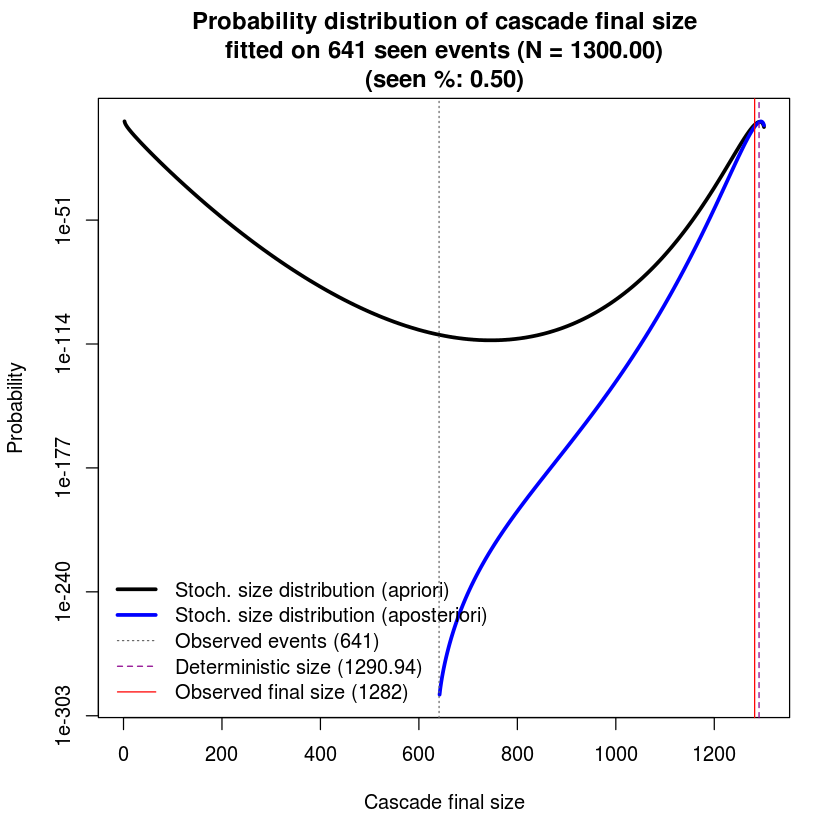

In [14]:
# plot our cascade
matplot(cbind(size.est.at.zero$final.state, size.est.at.end$final.state), 
        col = c('black', 'blue'), type = 'l', log = 'y', lty = c(1, 1), lwd = 3,
        xlab = 'Cascade final size', ylab = 'Probability',
        main = sprintf('Probability distribution of cascade final size\nfitted on %d seen events (N = %.2f)\n(seen %%: %.2f)', 
                       seenEvents, params.H['N'], seen_perc) )
abline(v = seenEvents, lty = 3, col = 'gray40')
abline(v = size.est.at.end$theo.mean, lty = 2, col = 'darkmagenta')
abline(v = nrow(history), lty = 1, col = 'red')
legend('bottomleft', 
        legend = c('Stoch. size distribution (apriori)', 
                   'Stoch. size distribution (aposteriori)',
                   sprintf('Observed events (%d)', seenEvents), 
                   sprintf('Deterministic size (%.2f)', size.est.at.zero$theo.mean), 
                   sprintf('Observed final size (%d)', nrow(history)) ), 
        lty = c(1, 1, 3, 2, 1), lwd = c(3, 3, 1, 1, 1), col = c('black', 'blue', 'gray40', 'darkmagenta', 'red'), bty = 'n')

Several observations (Sec 6.3 in our paper):
 - The apriori probability size distribution shows two maxima. This provides the following explanation for the general perceived unpredictability of online popularity. For cascades showing a bi-modal apriori size distribution, there are two likely outcomes: either it dies out early or it reaches a large size compared to the maximum population $N$. At time $t = 0$ is it impossible to di erentiate between the two outcomes.
 - The aposteriori probability distribution reflects the information gained from the observed events and it shows a single maximum towards the higher size values. The more events we observe, the higher the likelihood of the true value of cascade size.